In [2]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model
import torch

import warnings
warnings.filterwarnings("ignore")

model_path = ""
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_path)
)

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


In [3]:
image_file = ""
prompt='Please describe this image in detail.'
args = type('Args', (), {
    "model_base": None,
    "model_name": get_model_name_from_path(model_path),
    "query": prompt,
    "conv_mode": None,
    "image_file": image_file,
    "sep": ",",
    "temperature": 0,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 256,
    "model":model,
    "tokenizer":tokenizer,
    "image_processor":image_processor,
    "output_hidden_states": True,
    "return_dict_in_generate": True,
})()

all_output=eval_model(args)
output_text = tokenizer.decode(all_output['sequences'][0], skip_special_tokens=True)
print(output_text)

The image features a small child standing in a grassy field, wearing a striped shirt and a tie. The child appears to be crying, possibly due to the grass being too long or the outdoor environment. The child is surrounded by a lush green field, which provides a natural and serene setting for the scene.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
def plot_token_probabilities_area(token_probabilities, save_file='None', title="Token Probabilities Over Steps", 
                                  xlabel="Layers", ylabel="Probability"):
  
   
    plt.rcParams["font.family"] = "Times New Roman" 
    
 
    sns.set(style="whitegrid")  
    plt.figure(figsize=(14, 9))
    
 
    num_steps = len(next(iter(token_probabilities.values())))
    steps = range(0, num_steps)
    

    cmap = plt.get_cmap('tab20')  
    #colors = cmap(np.linspace(0, 1, len(token_probabilities)))
    colors = list(cmap(np.linspace(0, 1, len(token_probabilities))))
    #colors[0], colors[1] = colors[1], colors[0]
    
    
    labels=token_probabilities.keys()
    #labels = sorted(token_probabilities.keys(), key=lambda x: max(token_probabilities[x]))
    data = [token_probabilities[token] for token in labels]
    
   
    for token, prob, color in zip(labels, data, colors):
        plt.fill_between(
            steps, 
            prob, 
            label=token, 
            color=color, 
            alpha=0.6, 
            zorder=1  
        )
    
    
    for token, prob, color in zip(labels, data, colors):
        plt.plot(
            steps, 
            prob, 
            label=None,  
            color='black',    
            linewidth=0.2,     
            zorder=1         
        )
    

    plt.title(title, fontsize=38, fontweight='bold', color='black', pad=20)
    plt.xlabel(xlabel, fontsize=32, fontweight='bold', color='black', labelpad=15)
    plt.ylabel(ylabel, fontsize=32, fontweight='bold', color='black', labelpad=15)
    

    plt.gca().set_facecolor('white')  
    plt.gcf().set_facecolor('white')  
    
 
    plt.xticks(fontsize=28, fontweight='bold', color='black')
    plt.yticks(fontsize=28, fontweight='bold', color='black')
    
 
    plt.xlim(0, num_steps - 1)
    plt.ylim(0, 1)
    
 
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    legend = plt.legend(by_label.values(), by_label.keys(), fontsize=24, title_fontsize=28, loc='upper left')
    plt.setp(legend.get_title(), fontsize='14', fontweight='bold', color='black')
    
    plt.tight_layout()
    
    # 保存图表
    #plt.savefig(save_file, facecolor='white')
    plt.show()

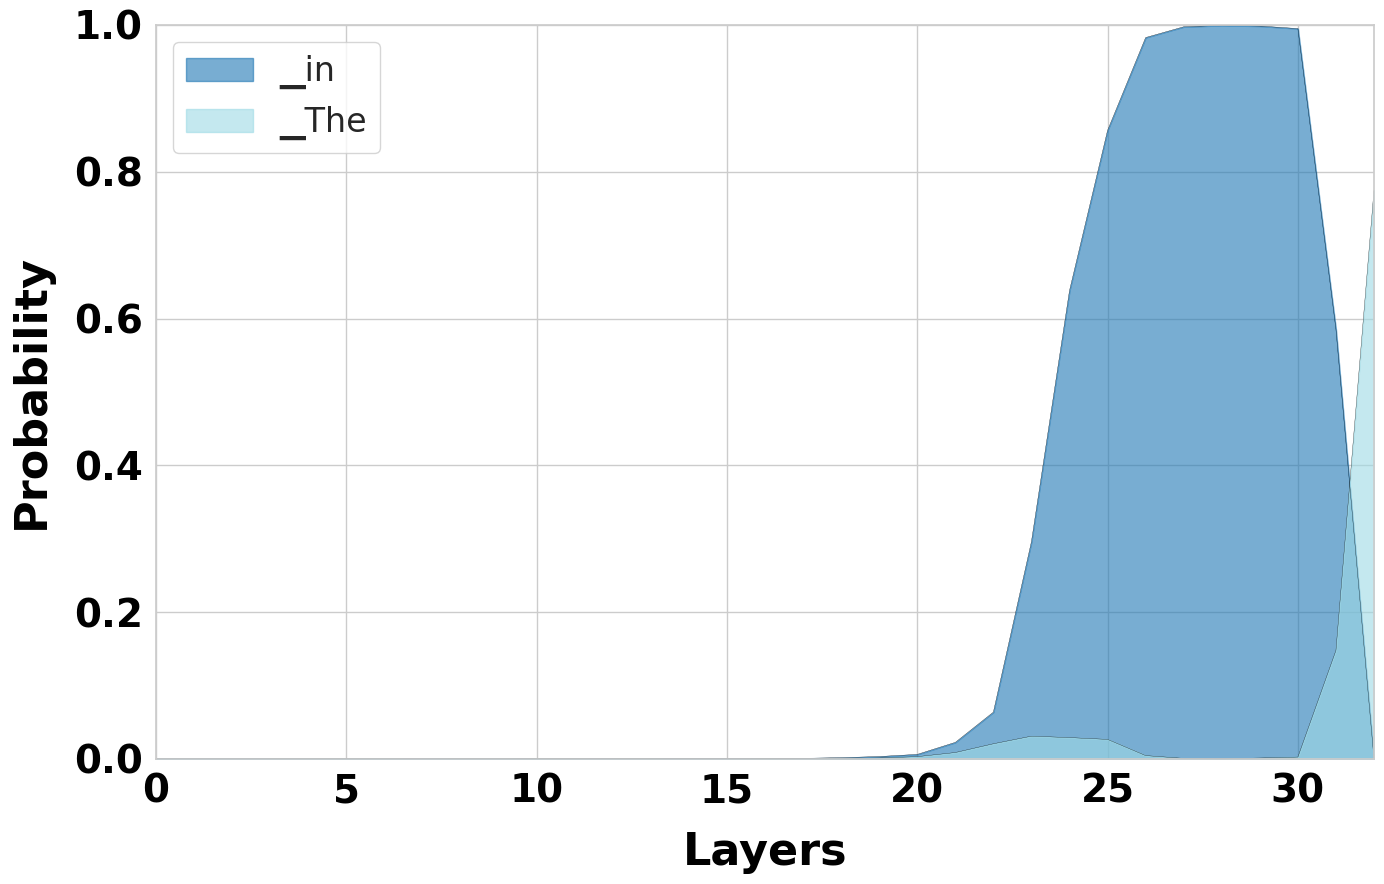

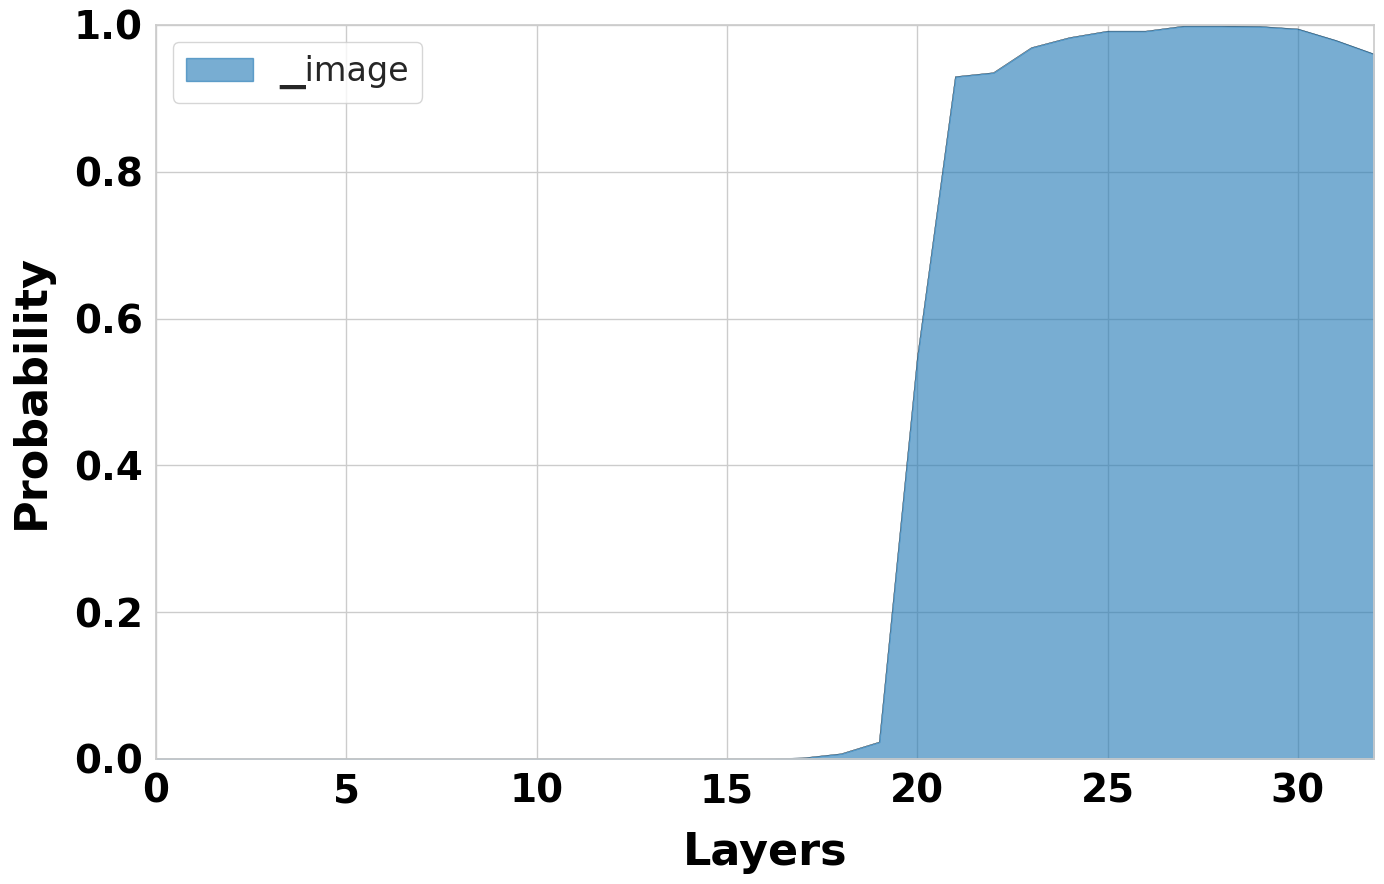

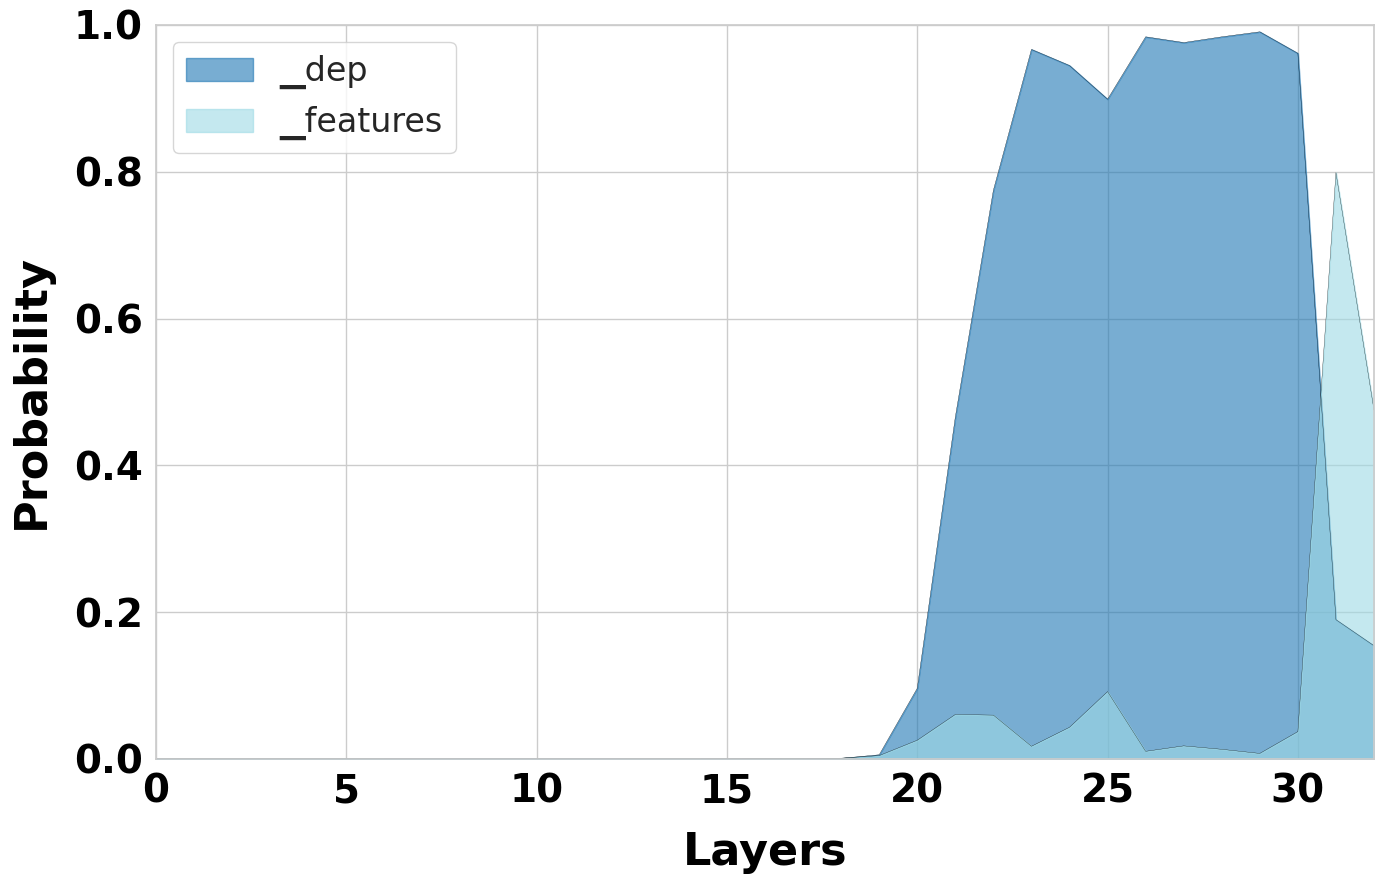

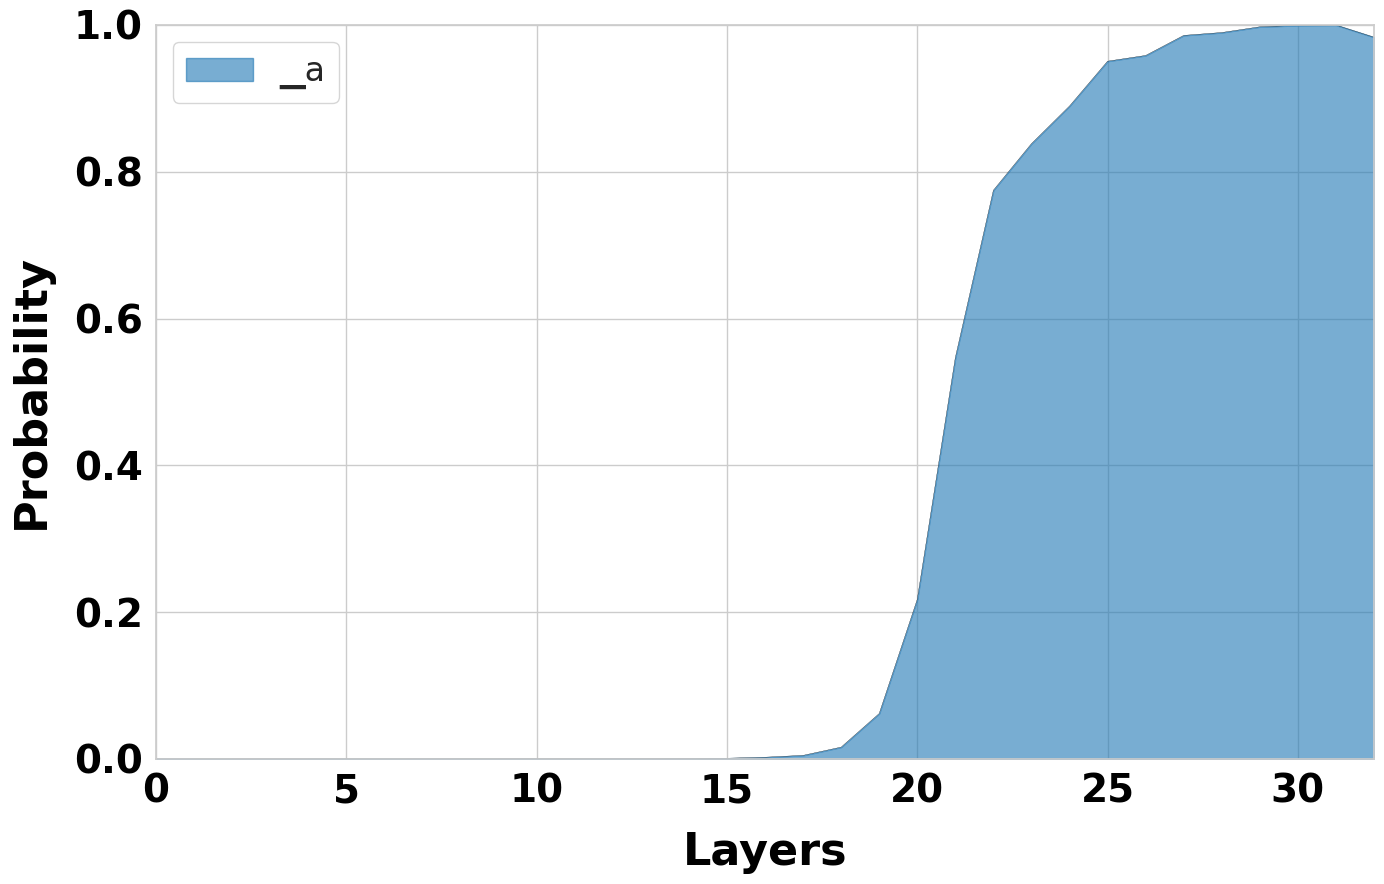

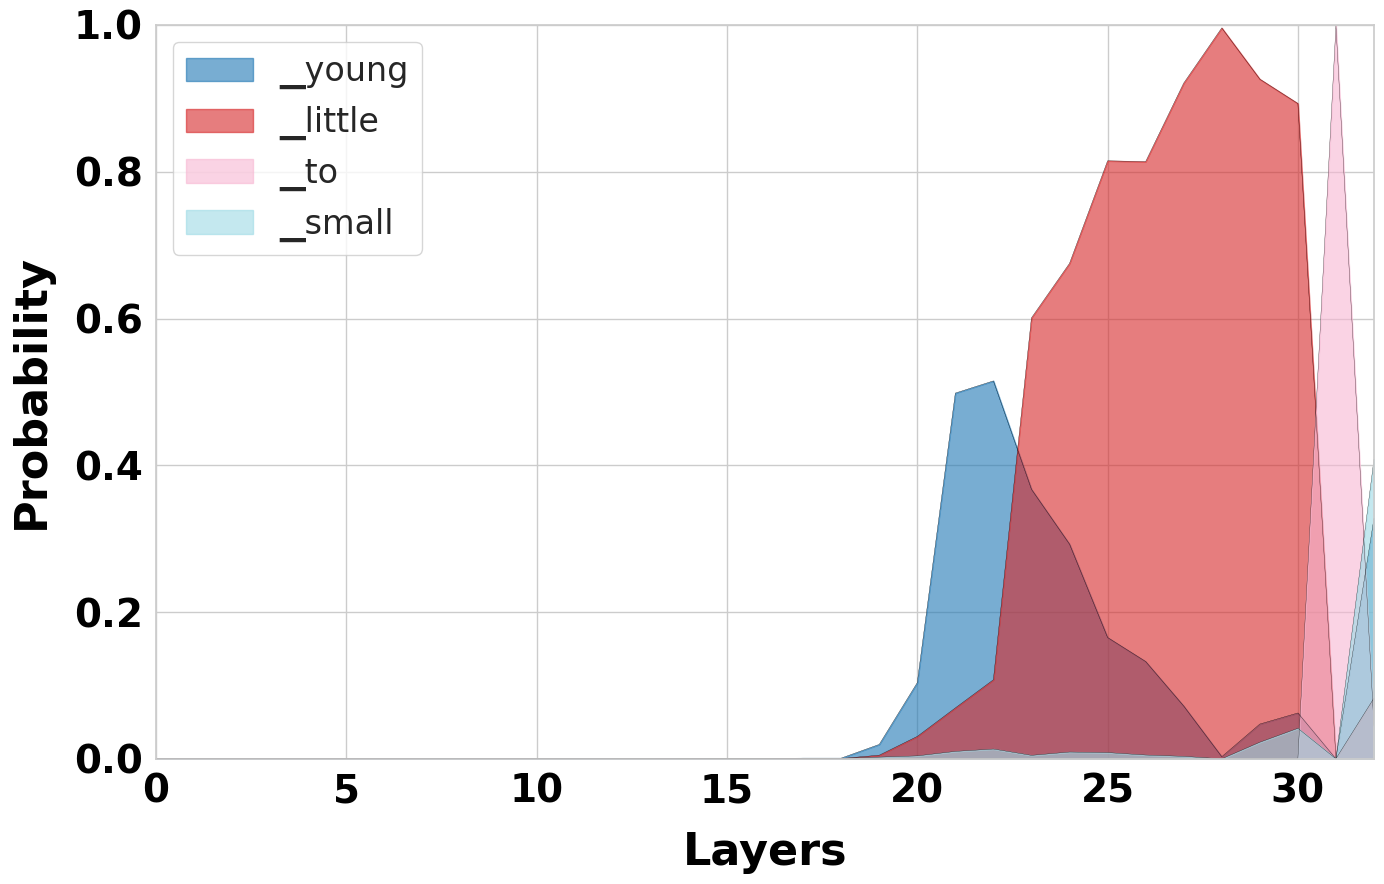

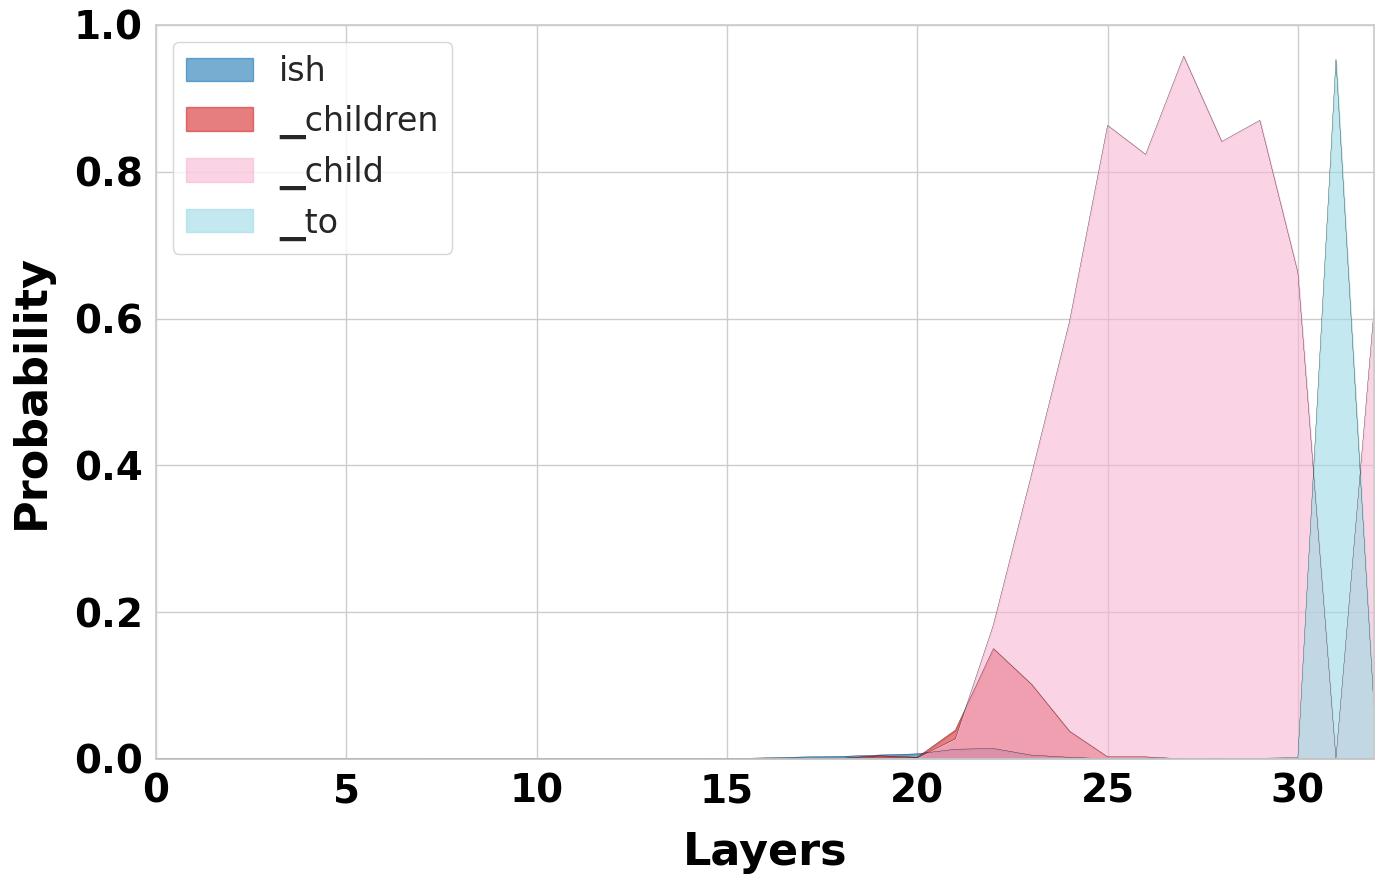

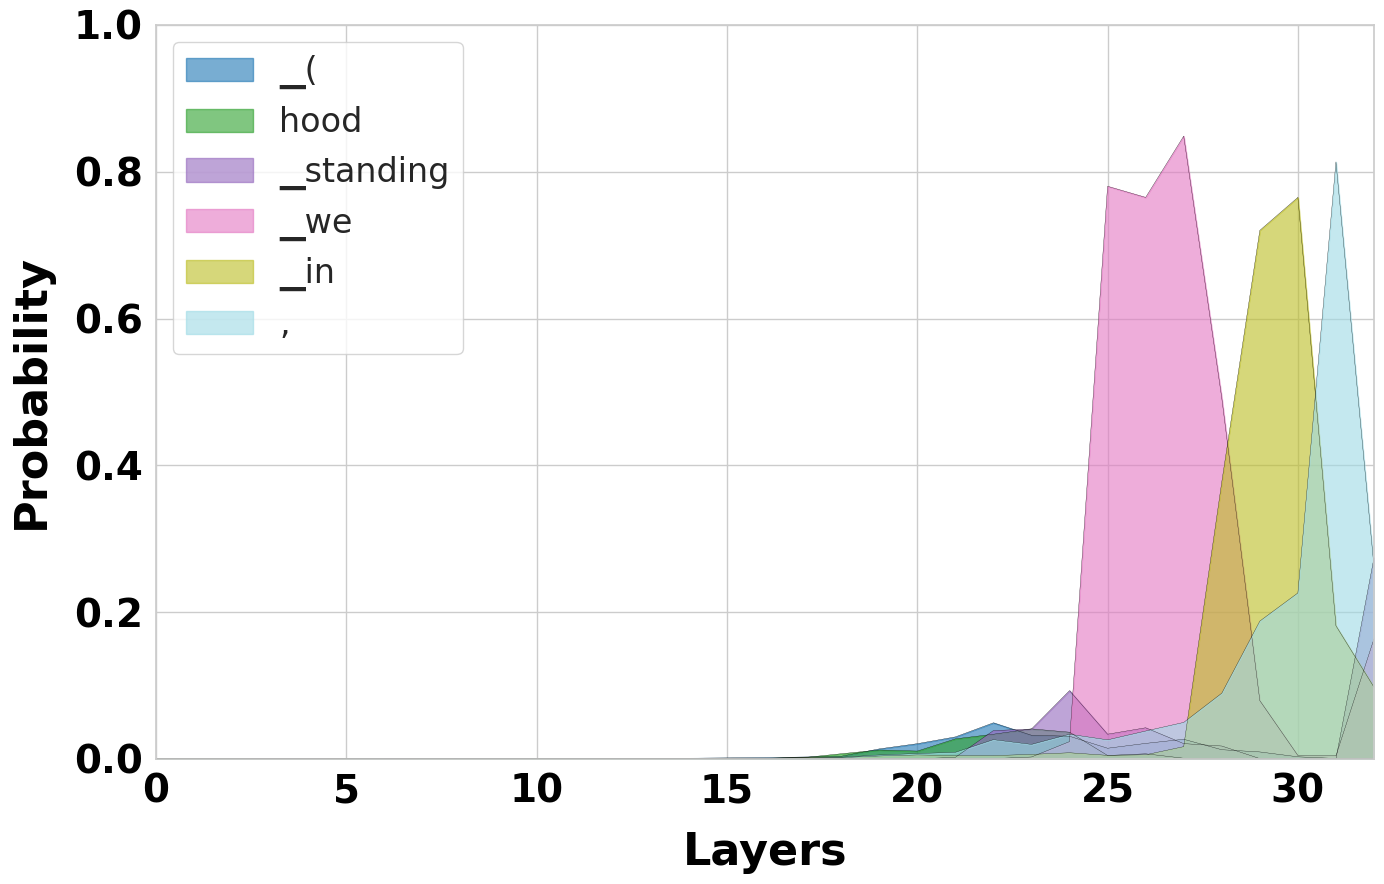

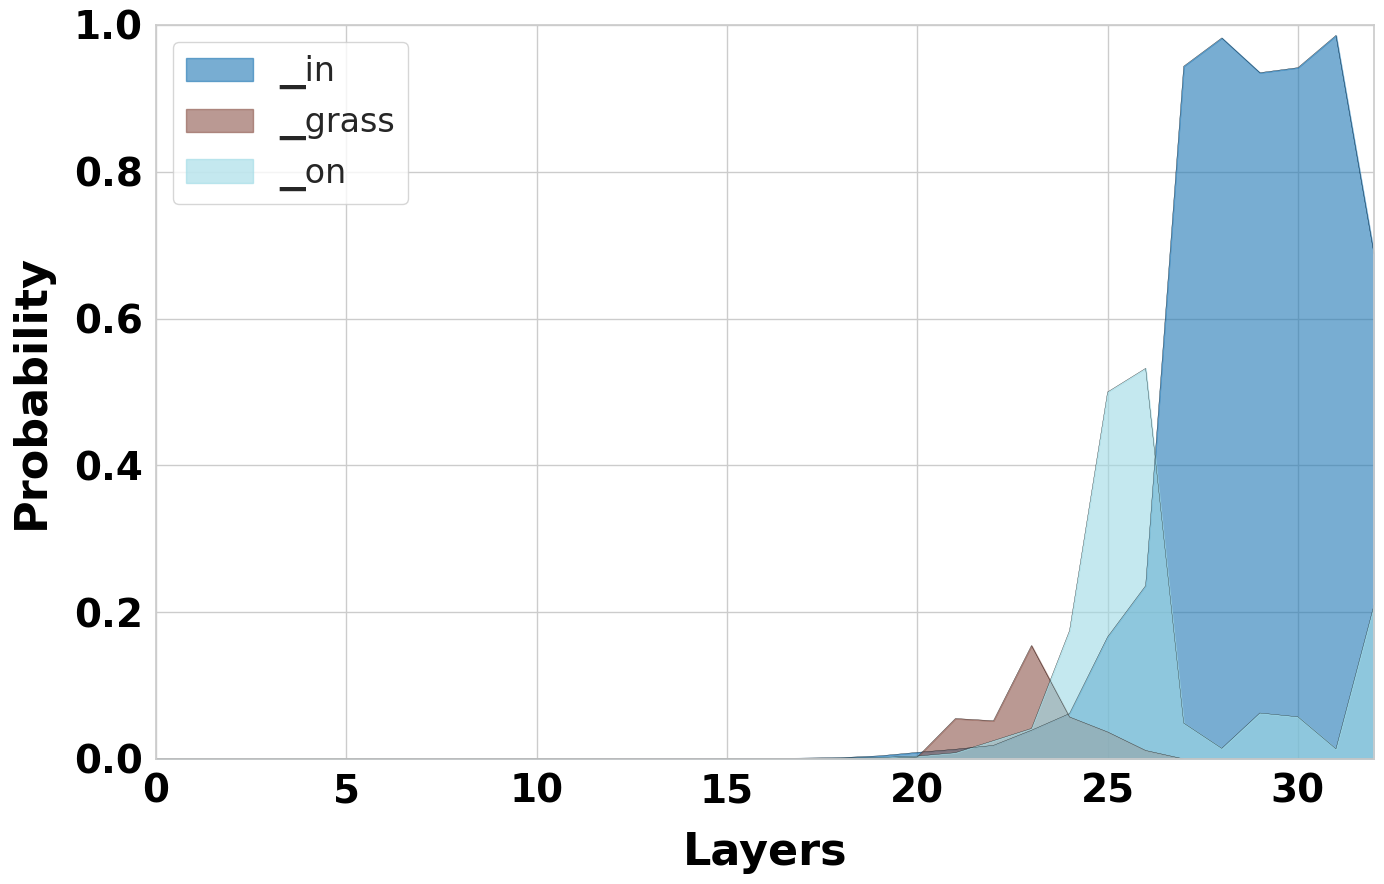

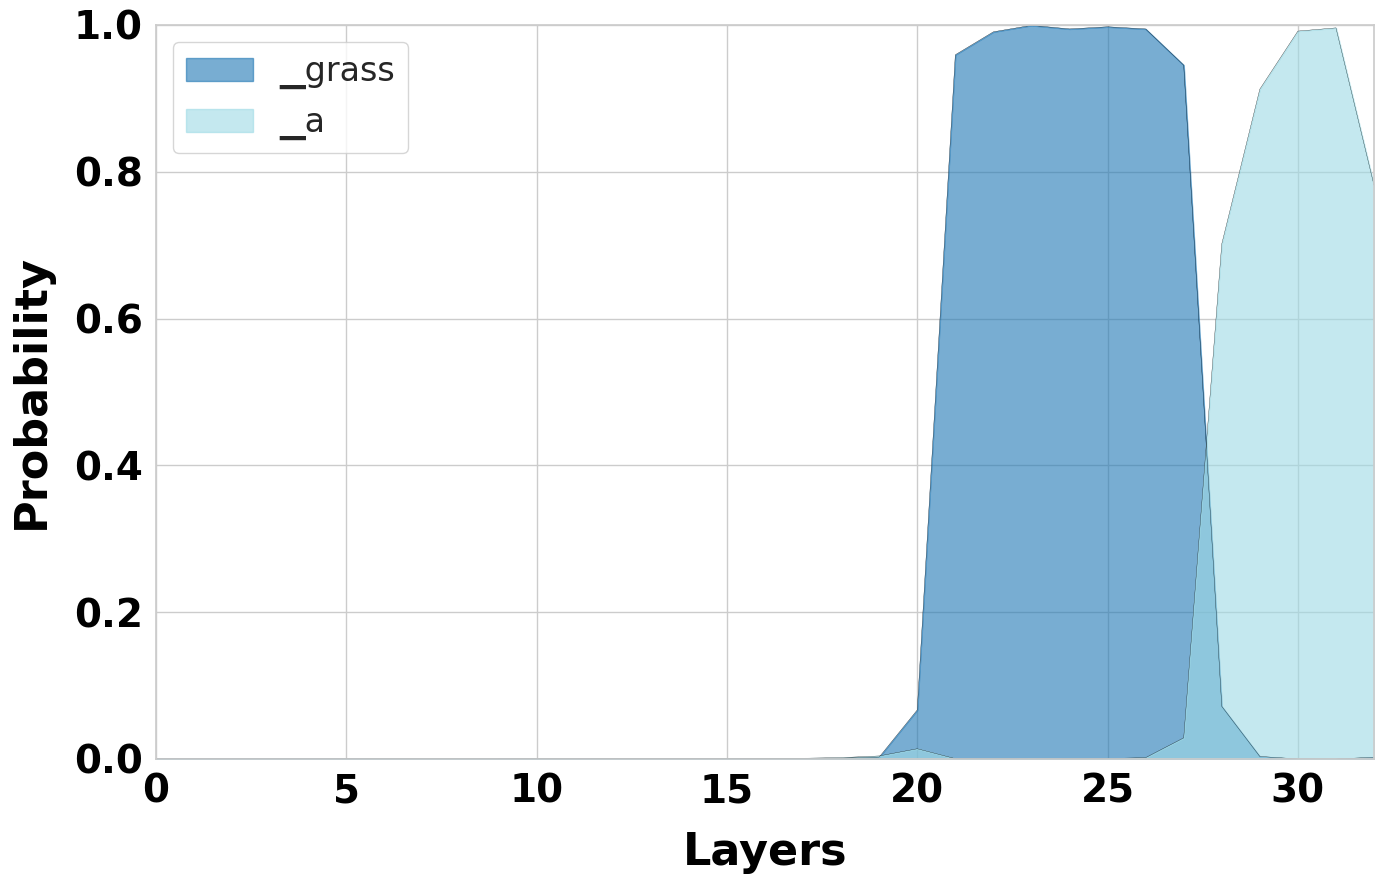

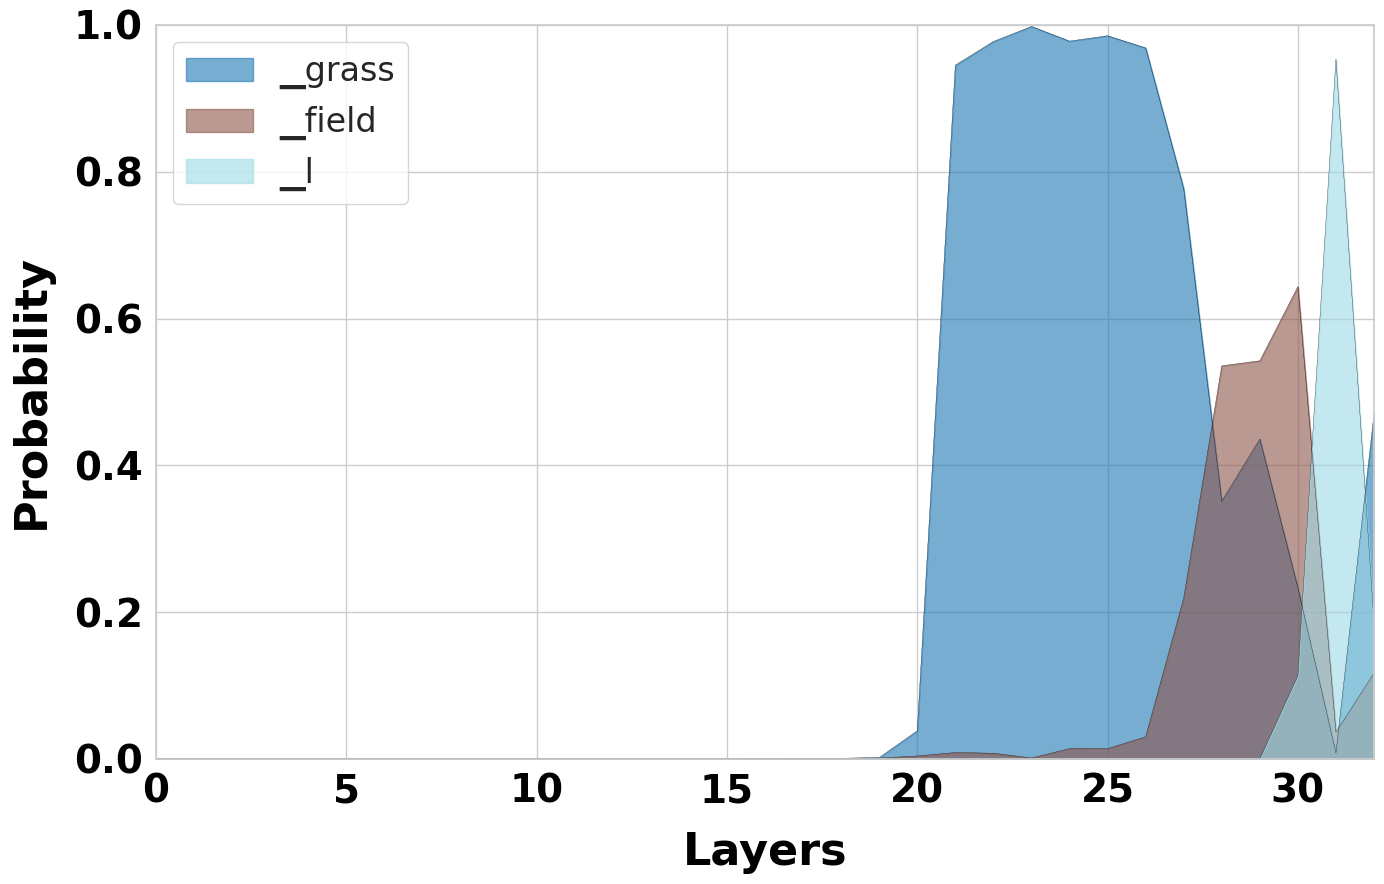

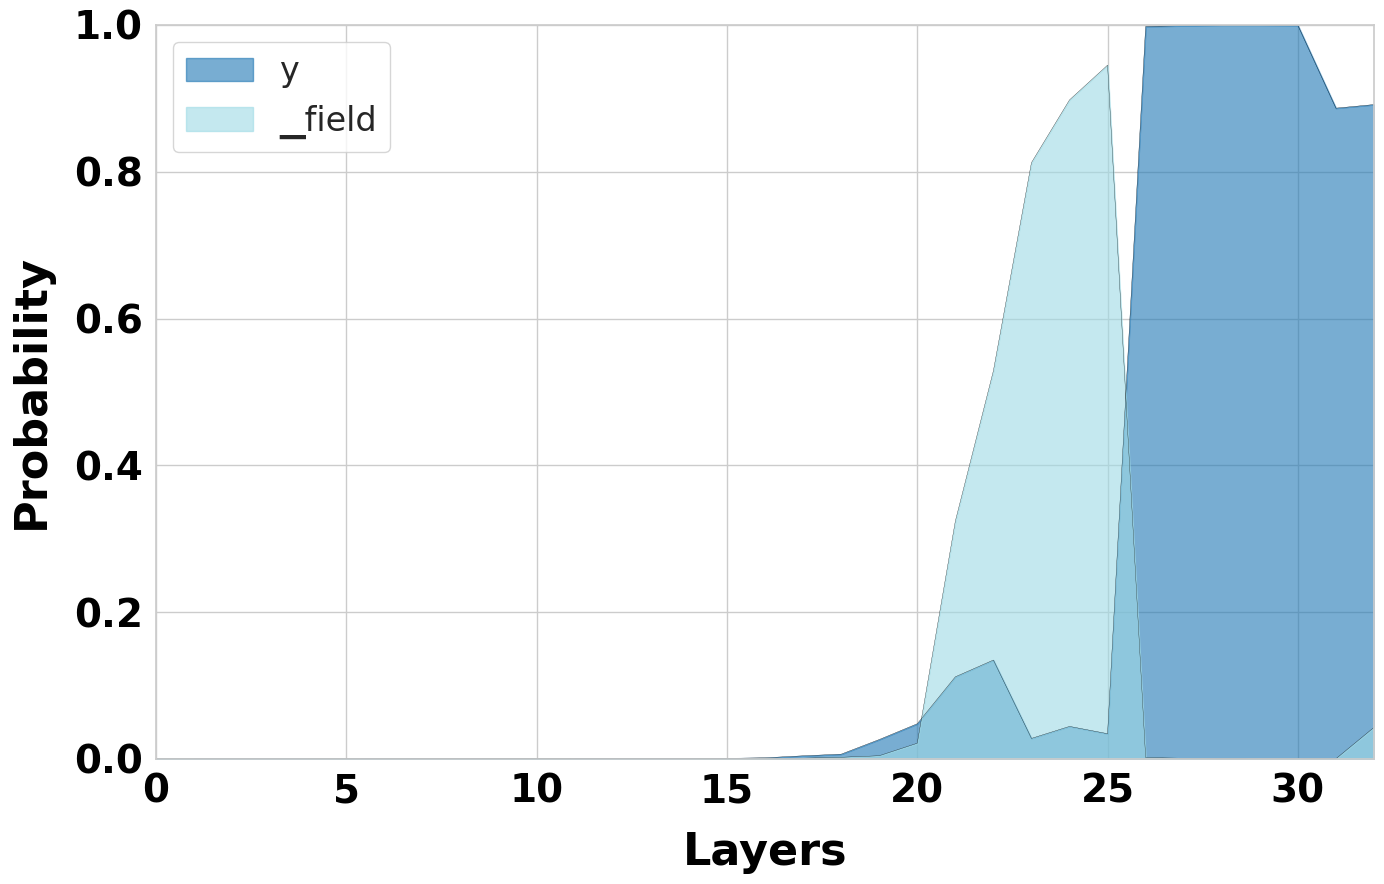

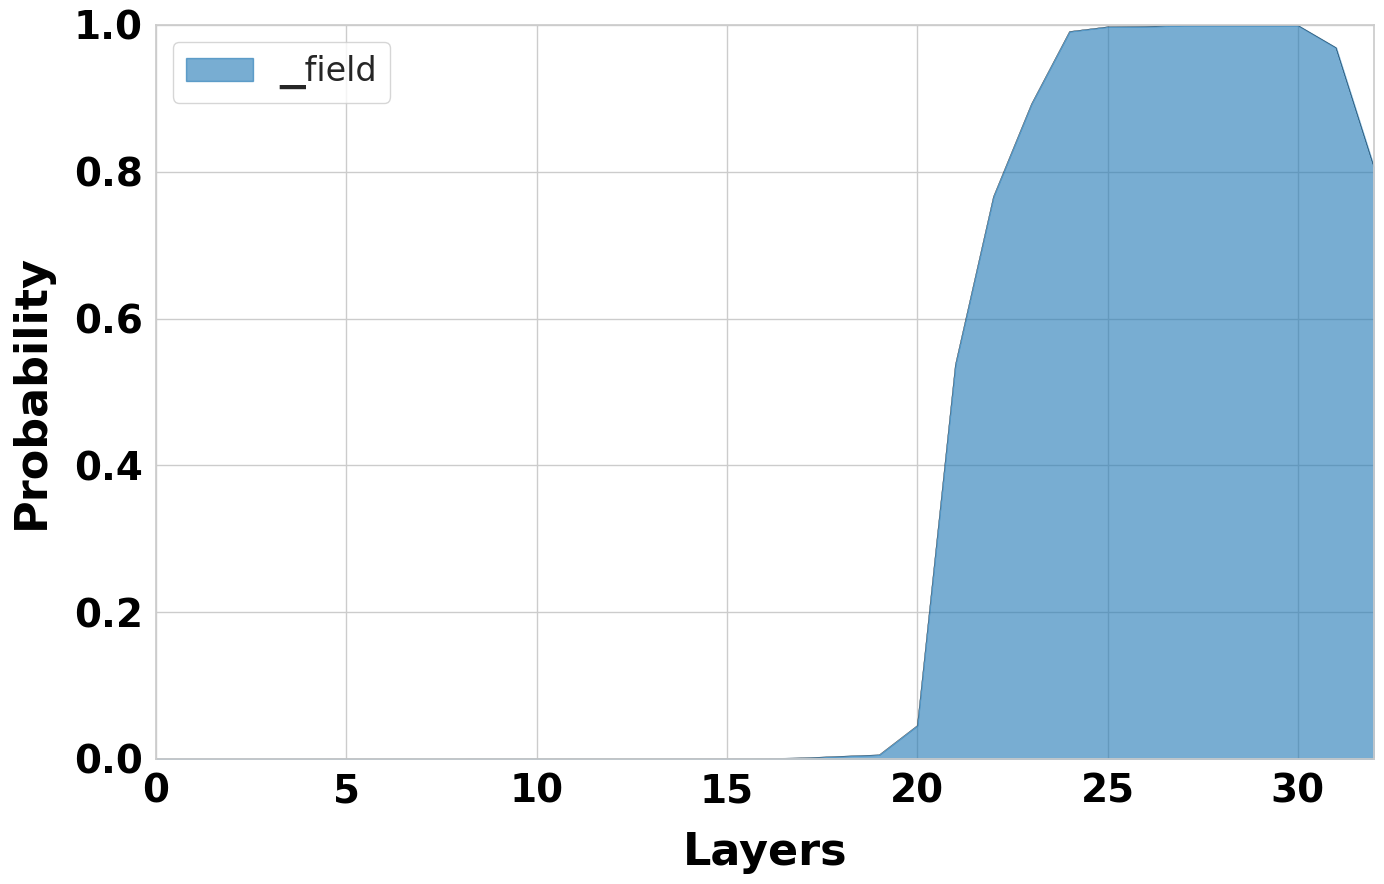

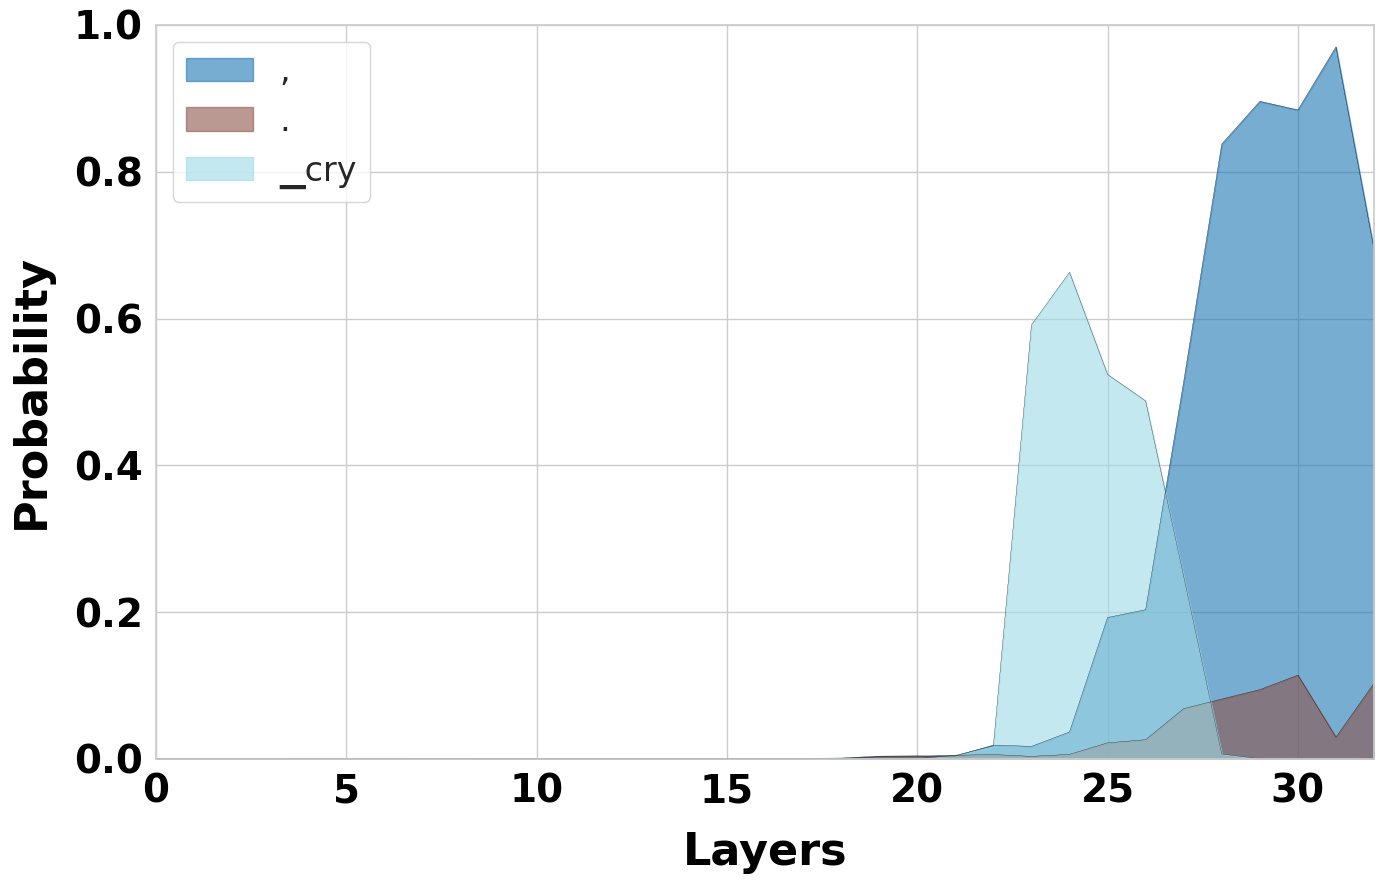

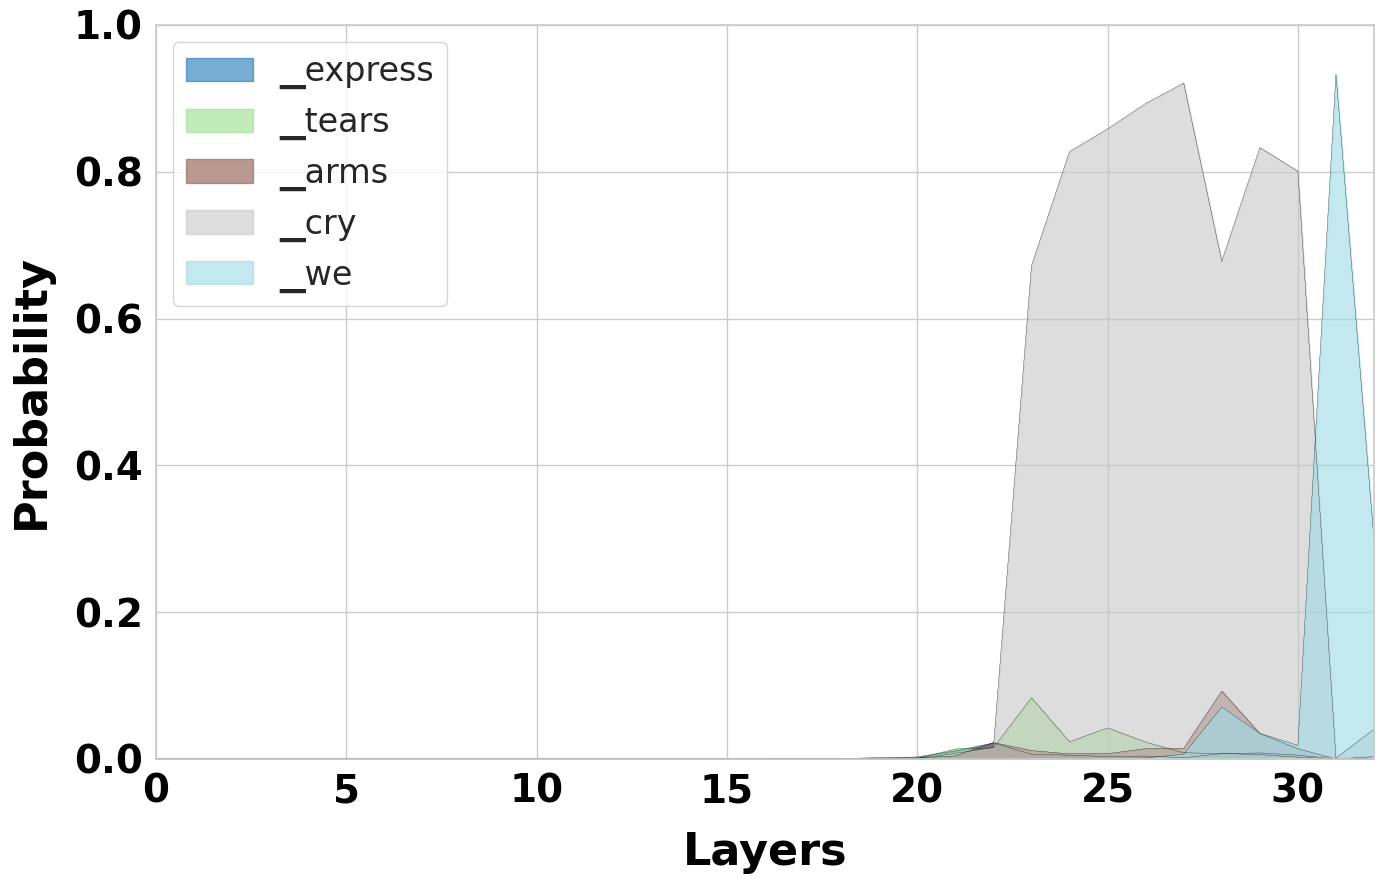

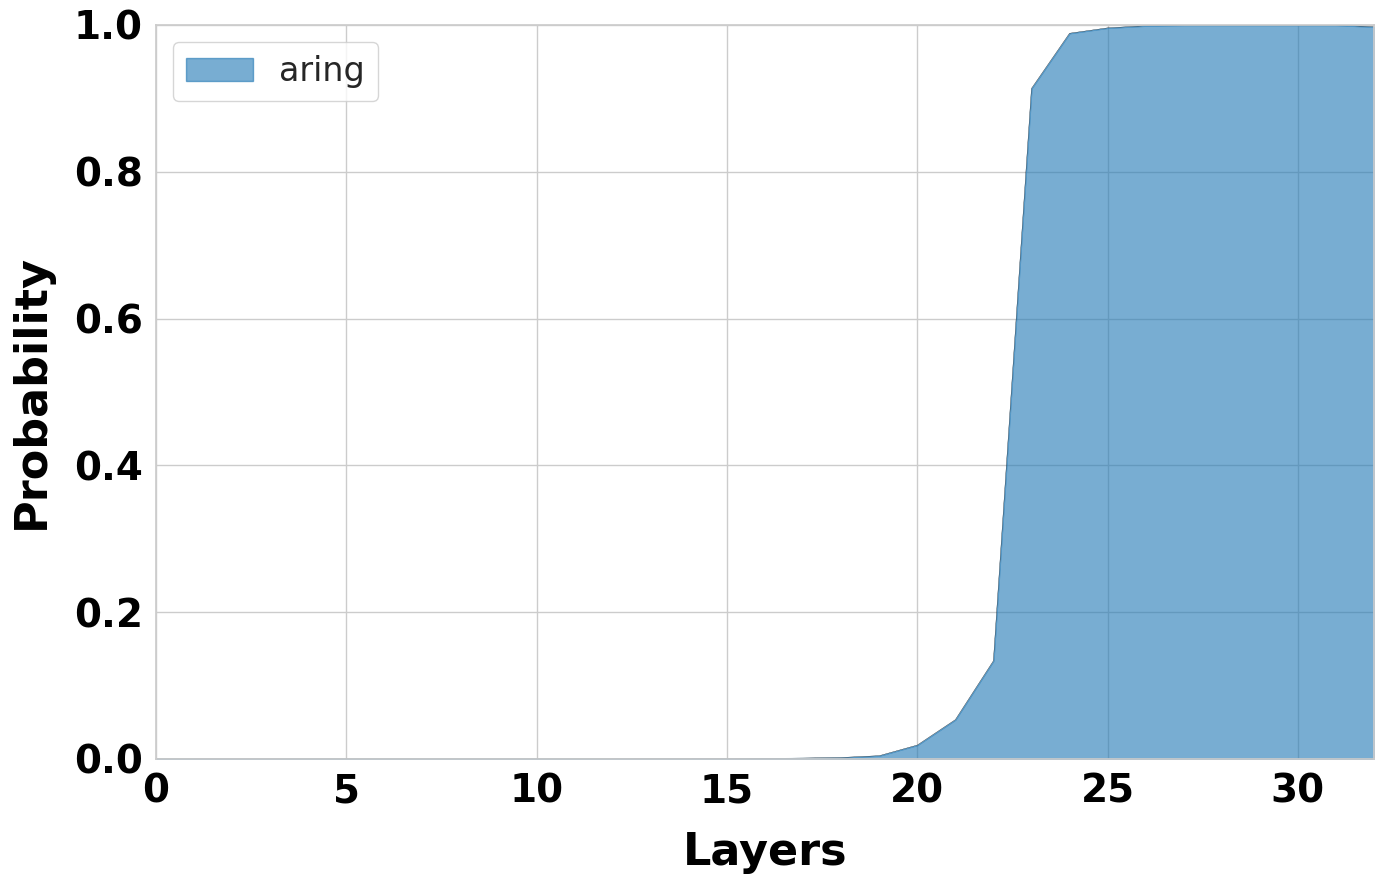

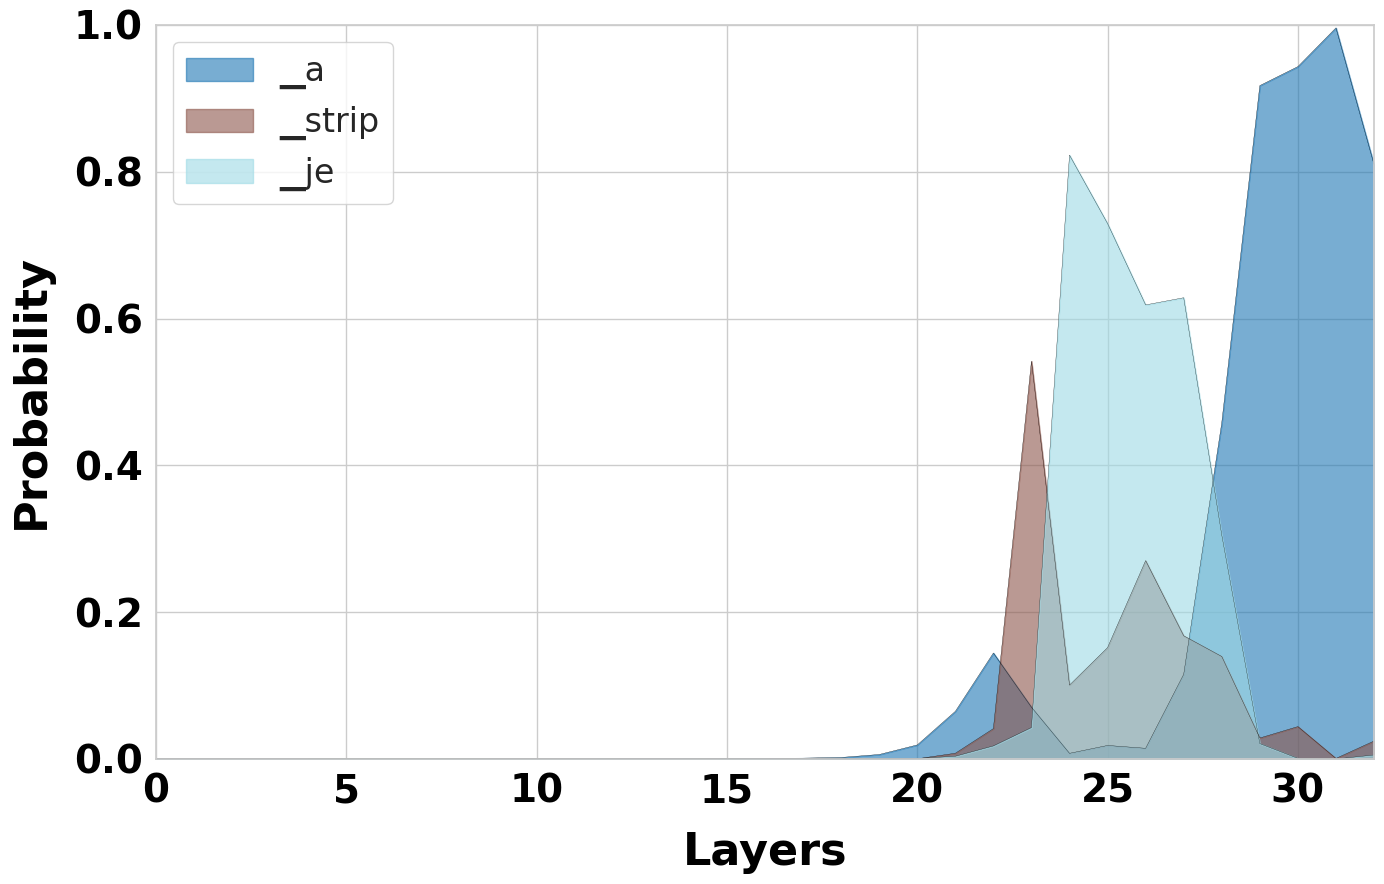

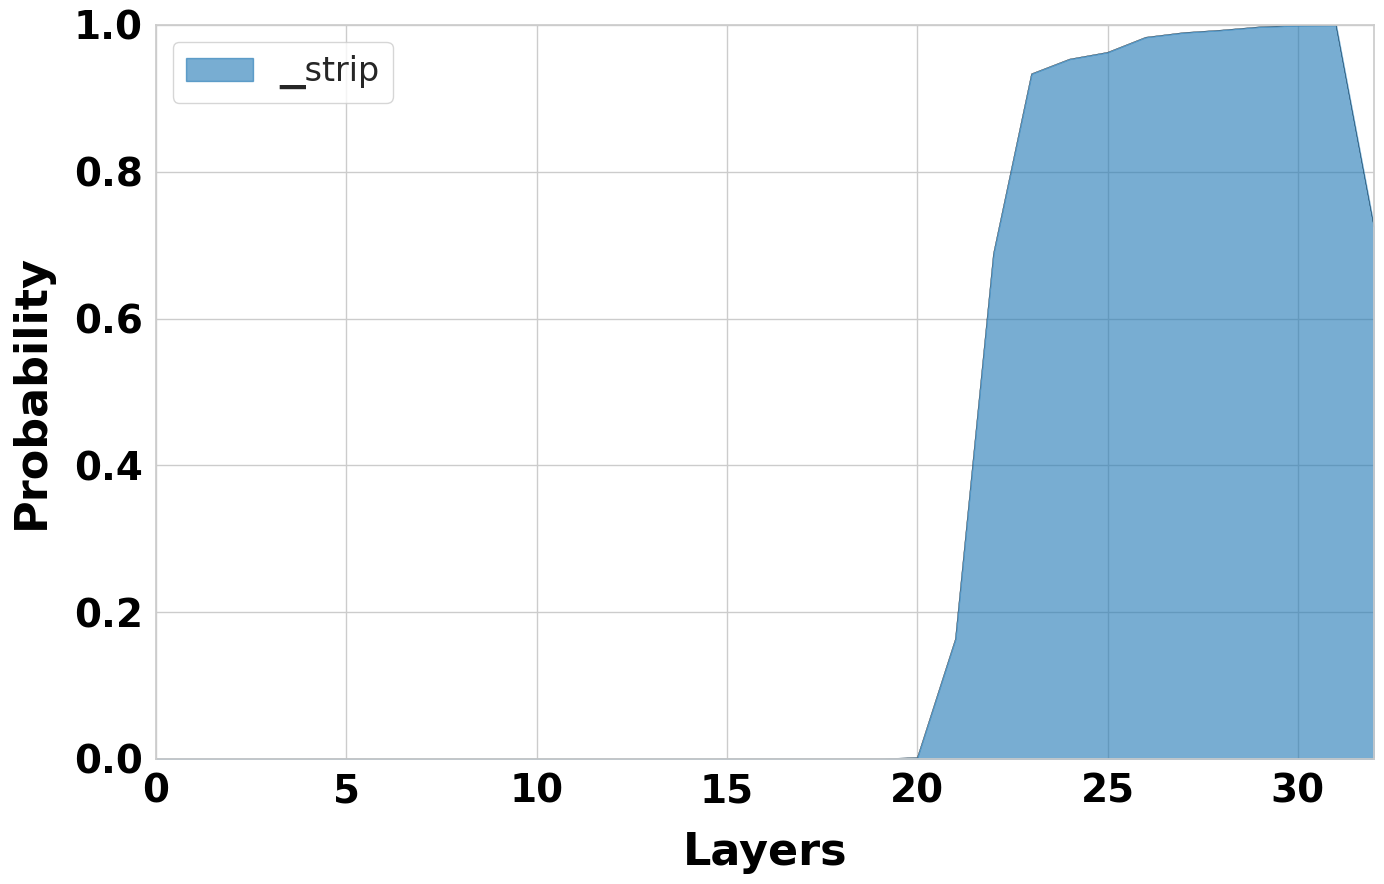

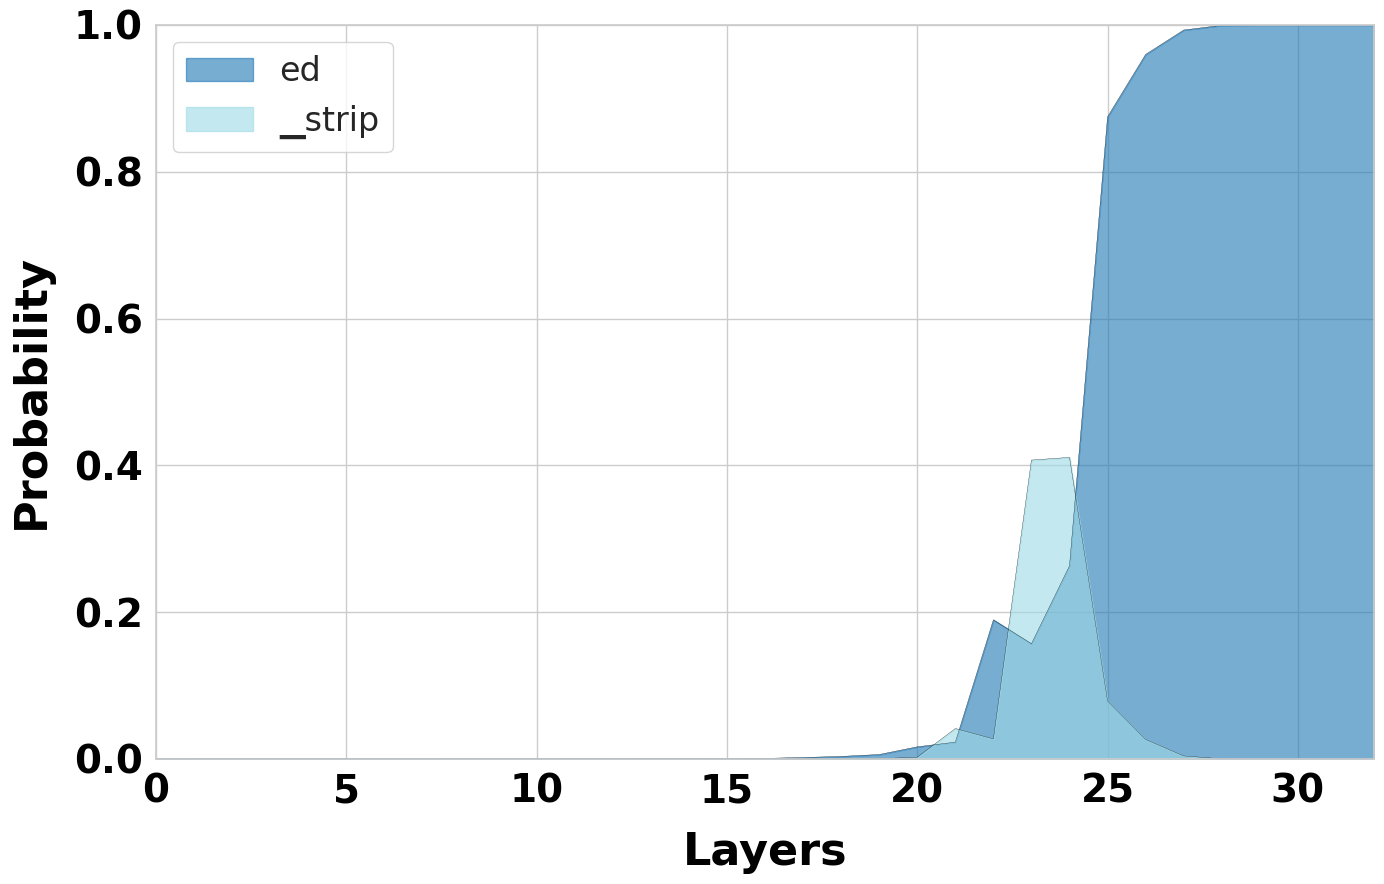

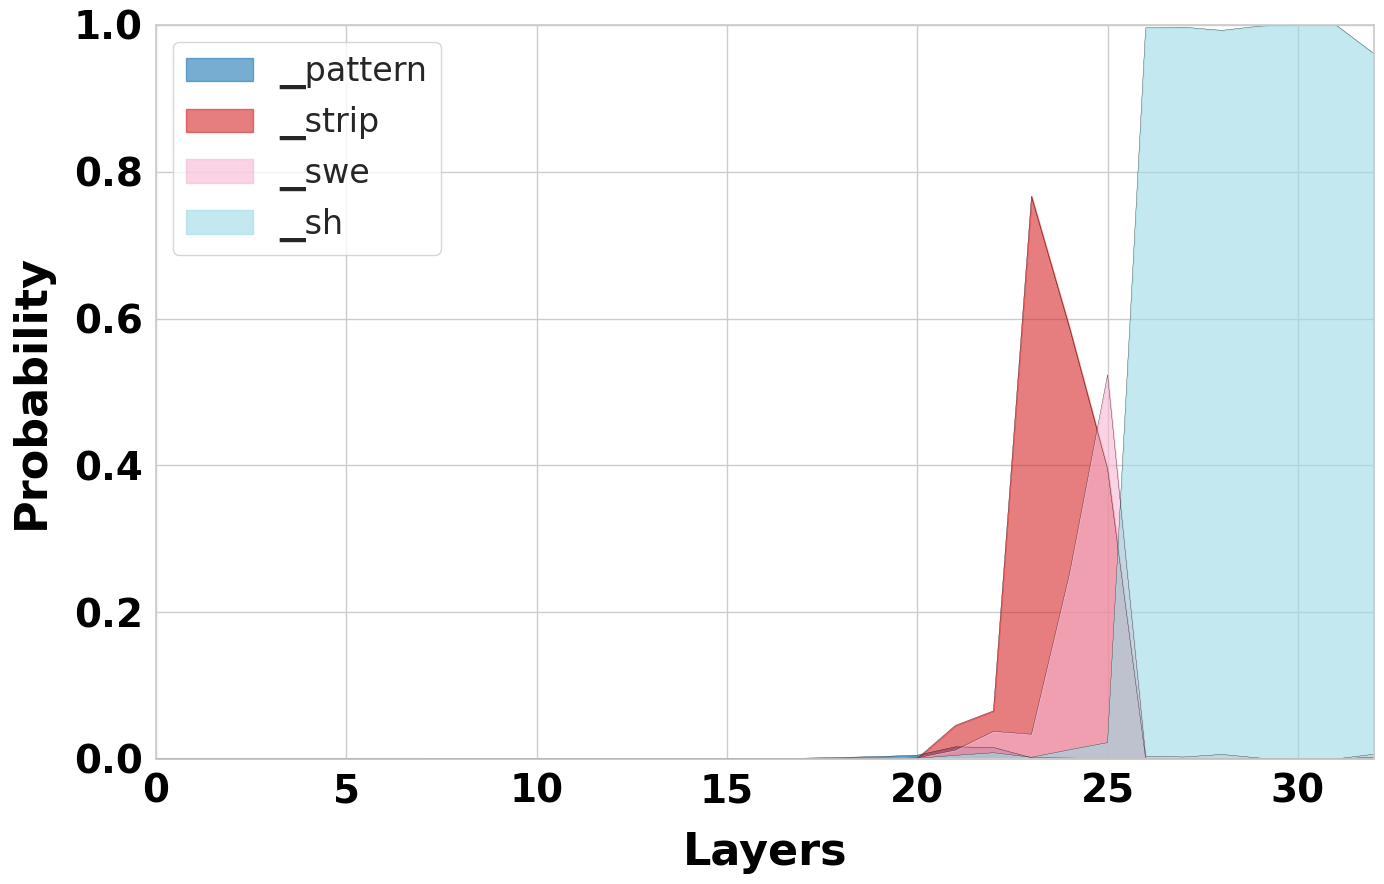

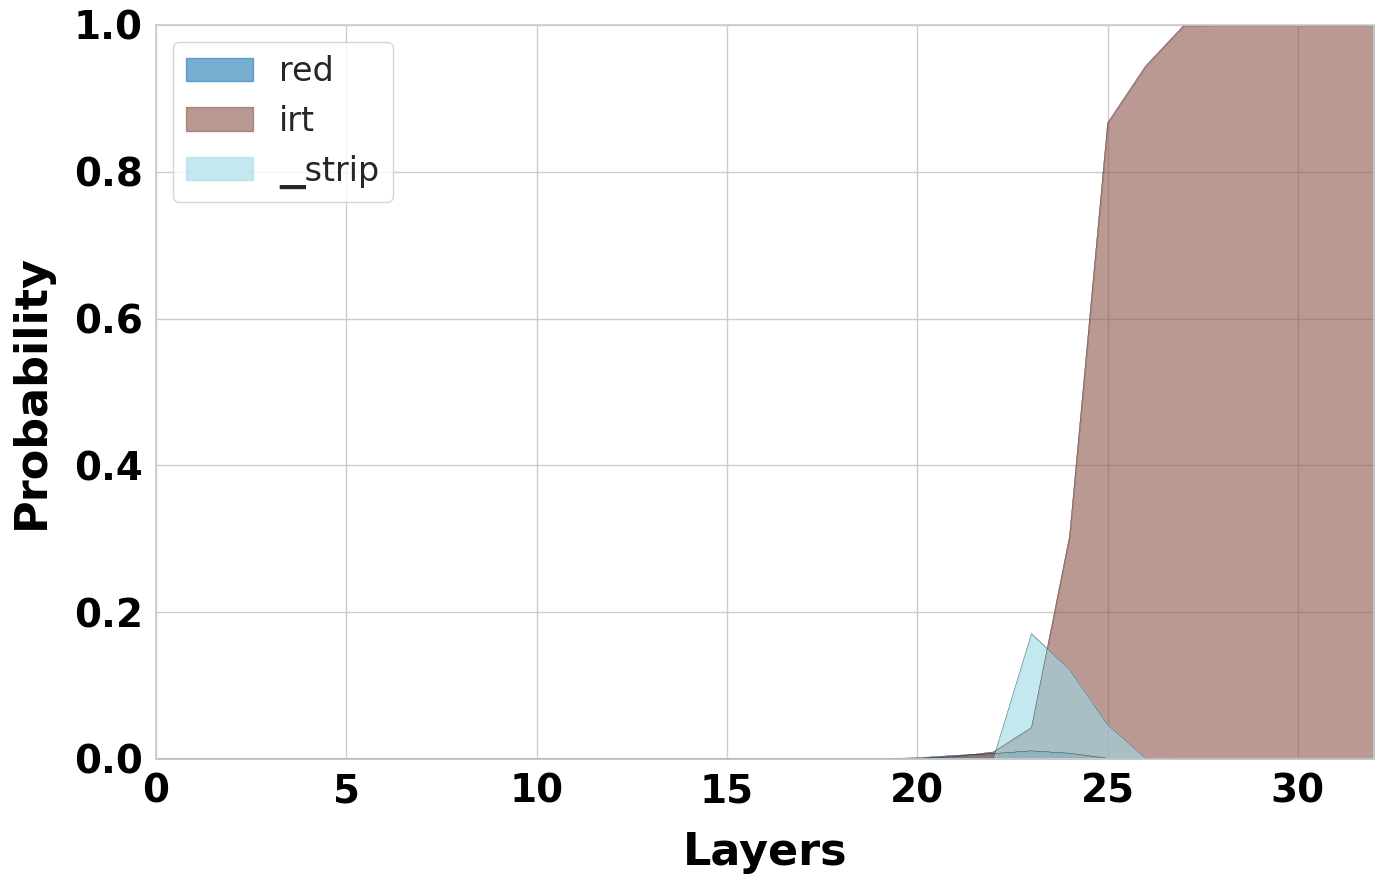

In [5]:
# Get the token sequence and hidden states from the model output.
# Exclude the first token because it is special and not generated by the model.('/s')
token_sequence = all_output["sequences"][0][1:]
hidden_states = all_output["hidden_states"]

# For a 7b model, use layers 20 to 32; for a 13b model, consider using layers 20 to 40.
part_layers = list(range(20, 33))

all_generated_tokens = []
all_token_ids = []

with torch.no_grad():
    # Loop over each time step in the hidden states.
    for j in range(len(hidden_states)):
        generated_tokens = {}

        # Extract the hidden states for the specified layers at the last token position.
        part_hidden_weights = [hidden_states[j][layer][:, -1, :] for layer in part_layers]

        # Compute logits for each selected layer.
        part_logits = [model.lm_head(hidden_weight) for hidden_weight in part_hidden_weights]

        # Record the original token (converted from its ID) with its index.
        original_token = tokenizer.convert_ids_to_tokens(token_sequence[j].item())
        generated_tokens[original_token] = j

        # For each selected layer, get the token with the highest logit.
        for layer, logits in zip(part_layers, part_logits):
            predicted_token_id = logits.argmax(dim=-1)
            predicted_token = tokenizer.convert_ids_to_tokens(predicted_token_id.item())
            generated_tokens[layer] = predicted_token

        all_generated_tokens.append(generated_tokens)

    # For each time step, create a mapping of predicted tokens to their token IDs,
    # skipping the first entry (which is the original token).
    for j in range(len(hidden_states)):
        token_ids = {
            token: tokenizer.convert_tokens_to_ids(token)
            for token in list(all_generated_tokens[j].values())[1:]
        }
        all_token_ids.append(token_ids)

    for j in range(20):  # choose which token you want to analyze
        # Define all layers (0 to 32 for a 7b model).
        all_layers = list(range(33))
        
        # Extract the hidden state for the last token from all layers.
        target_hidden_weights = [hidden_states[j][layer][:, -1, :] for layer in all_layers]
        # Compute logits from these hidden states.
        target_logits = [model.lm_head(hidden_weight) for hidden_weight in target_hidden_weights]

        # Initialize a dictionary to store probabilities for each token of interest.
        token_probabilities = {token: [] for token in all_token_ids[j].keys()}

        # Iterate over each layer's logits.
        for layer_idx, logits in enumerate(target_logits):
            # Apply softmax to convert logits into a probability distribution.
            probabilities = F.softmax(logits, dim=-1)
            # For each token, compute its probability.
            for token, token_id in all_token_ids[j].items():
                # Calculate the mean probability for the token across the batch.
                token_prob = probabilities[:, token_id].mean().item()
                token_probabilities[token].append(token_prob)
                # print(
                #     f"Layer {layer_idx}: Probability of token_id {token_id} ('{token}') -> {token_prob:.6f}"
                # )

        # Plot the token probabilities using a custom plotting function.
        plot_token_probabilities_area(token_probabilities, title='')